In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

### Analysis

In [2]:
import pyemma
pyemma.__version__

'2.5.7'

In [3]:
h5file = "./data/cossio_kl1.3_Dx1_Dq1.h5"
f = h5py.File(h5file, 'r')
data0 = np.array(f['data'])
f.close()
X = data0[:,[1,2]]

In [4]:
X0, X1 = X[:,0], X[:,1]
X.shape, X0.shape, X1.shape

((25001, 2), (25001,), (25001,))

In [5]:
from pyemma.util.contexts import settings
import pyemma.coordinates as coor
import pyemma.plots as mplt

Check x and q coordinates along the trajectory.

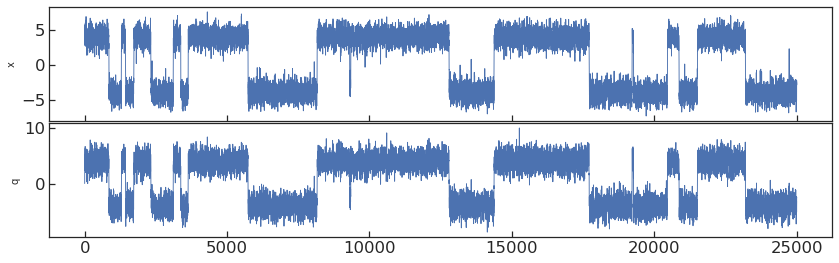

In [7]:
fig, ax = plt.subplots(2,1,figsize=(12,4), sharex=True,sharey=False)
ax[0].plot(range(len(X[:,0])), X[:,0], linewidth=0.9)
ax[1].plot(range(len(X[:,1])), X[:,1], linewidth=0.9)
ax[0].set_ylabel('x', fontsize=10)
ax[1].set_ylabel('q', fontsize=10)
plt.tight_layout(h_pad=0)

In [8]:
inp = coor.source([data0])

In [9]:
print ('number of trajectories = ', inp.ntraj)
print('1st trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())

number of trajectories =  1
1st trajectory length =  25001
number of dimension =  3


### Traditional MSM construction

In [10]:
cl = coor.cluster_kmeans(data=[X], k=50, max_iter=150) #, stride=1
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
ccx = cl.clustercenters[:,0]
ccy = cl.clustercenters[:,1]

In [11]:
cl.clustercenters[0]

array([5.0430856, 3.9562423], dtype=float32)

Generate the free energy surface described by Cossio et al. and plot together with the cluster centers resulting from K-means clustering.

In [15]:
import cossio
yp = np.linspace(-10.,10.,400)
xp = np.linspace(-10.,10.,400)
mat = np.zeros((len(xp), len(yp)))
for i, x_i in enumerate(xp):
    for j, y_i in enumerate(yp):
        aux = cossio.Gqx(x_i,y_i, kl=1.3)
        mat[i, j] = aux

Xpp, Ypp = np.meshgrid(xp,yp)

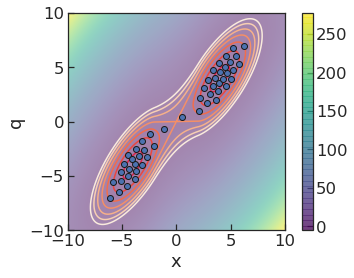

In [16]:
fig, ax = plt.subplots()
lev = np.arange(-15,5,1.5)
CS = ax.contour(Xpp, Ypp, mat, levels=lev)
ax.plot(ccx,ccy, linewidth=0, marker='o', mfc='b', mec='k')
im = ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
           cmap='viridis', alpha=0.5);
plt.colorbar(im)
ax.set_xlabel('x')
ax.set_ylabel('q')
yt = np.arange(-10,10,5)
ax.set_yticks([-10,-5,0,5,10])

Construct the MSM corresponding to the aforementioned discretization.

In [17]:
import pyemma.msm as msm
import pyemma.plots as mplt
lags = [1, 2, 5, 10, 20, 30]

its = msm.its(dtrajs, lags=lags, errors='bayes')

(0.1, 1000)

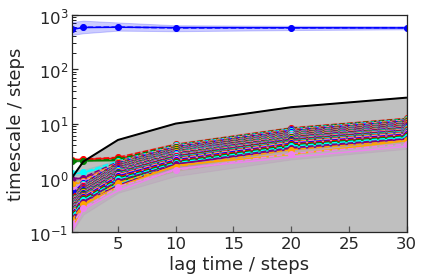

In [18]:
mplt.plot_implied_timescales(its, ylog=True)
plt.ylim(0.1,1000)

In [19]:
M = msm.estimate_markov_model(dtrajs, 10)

In [20]:
M.timescales()[:2]

array([583.688787  ,   3.56362433])

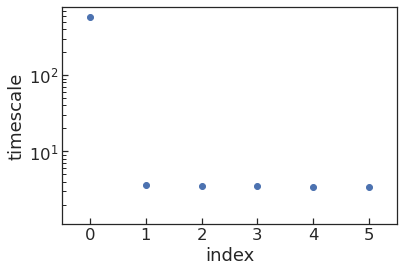

In [21]:
plt.plot(M.timescales(),linewidth=0,marker='o')
plt.xlabel('index')
plt.ylabel('timescale')
plt.xlim(-0.5,5.5)
#plt.ylim(6,400)
plt.yscale('log')

Since there is a single slow process, let us lump the microstates into two macrostates by using PCCA+ spectral clustering.

In [22]:
M.pcca(2)

PCCA(P=array([[0.02933, 0.00279, ..., 0.     , 0.056  ],
       [0.00121, 0.07624, ..., 0.0394 , 0.00121],
       ...,
       [0.     , 0.07615, ..., 0.04177, 0.     ],
       [0.02367, 0.00118, ..., 0.     , 0.06764]]),
   m=2)

In [24]:
pcca_sets = M.metastable_sets

Text(0, 0.5, 'q')

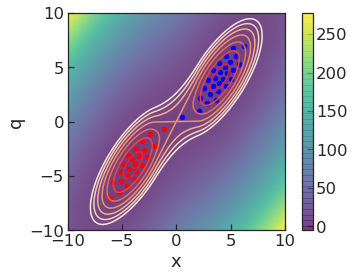

In [25]:
fig, ax = plt.subplots()
lev = np.arange(-15,5,1.5)
CS = ax.contour(Xpp, Ypp, mat, levels=lev)
ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
           cmap='viridis', alpha=0.5);#RdGy
ax.scatter(cl.clustercenters[pcca_sets[0],0], cl.clustercenters[pcca_sets[0],1], color='red', s=20)
ax.scatter(cl.clustercenters[pcca_sets[1],0], cl.clustercenters[pcca_sets[1],1], color='blue', s=20)
im = ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
           cmap='viridis', alpha=0.5);
plt.colorbar(im)
ax.set_xlabel('x')
ax.set_ylabel('q')

Chapman-Kolmogorov test for the MSM resulting from PCCA+ clustering.

In [26]:
M = msm.bayesian_markov_model(dtrajs, 10)

In [27]:
ck = M.cktest(2) #M.cktest(3)

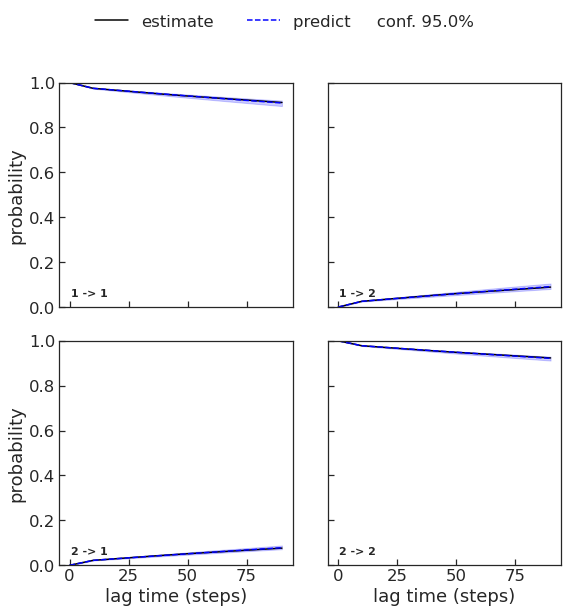

In [28]:
plt.rcParams.update({'font.size': 11})
fig, axes = mplt.plot_cktest(ck, figsize=(9, 9), padding_between=0.15, padding_top=0.13)

#mplt.plot_cktest(ck)

### MSM construction exploting density-based clustering

In [29]:
import hdbscan

In [30]:
data = np.vstack((X))

In [31]:
np.shape(data)

(25001, 2)

Apply HDBSCAN clustering with 'minimum cluster size' equal to 50 and 'minimum samples' equal to 70 to previously normalized data. Then look into resulting clusters.

In [32]:
from sklearn.preprocessing import StandardScaler
norm_X = StandardScaler().fit_transform(data)

In [33]:
hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=70).fit(norm_X)

In [34]:
np.unique(hdb.labels_)

array([-1,  0,  1])

-1 cluster label denotes 'noise', so two clusters are obtained from HDBSCAN clustering. The latter can be better understood from the corresponding condensed tree plot. For more details see https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

<AxesSubplot:ylabel='$\\lambda$ value'>

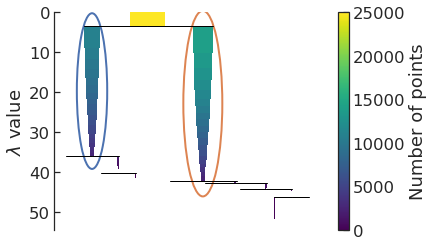

In [35]:
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
hdb.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

Text(0, 0.5, 'q')

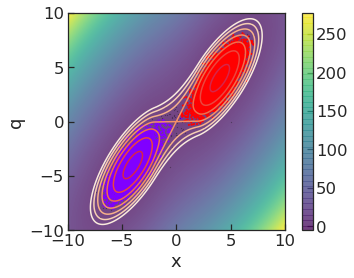

In [36]:
fig, ax = plt.subplots()
assign = hdb.labels_ >= 0
ax.scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(data[nassign,0],data[nassign,1], marker='.', 
                cmap='rainbow', s=0.1, c='k')
lev = np.arange(-15,5,1.5)
CS = ax.contour(Xpp, Ypp, mat, levels=lev)
ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
           cmap='viridis', alpha=0.5);#RdGy
im = ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
           cmap='viridis', alpha=0.5);#RdGy
plt.colorbar(im)
ax.set_xlabel('x')
ax.set_ylabel('q')

In order to be more stringent with the TBA methodology, let us set as 'noise' those points whose probability to be in their corresponding clusters is less than 40%.

In [37]:
for i, x_i in enumerate(hdb.labels_):
    if hdb.probabilities_[i] < 0.4:
        hdb.labels_[i] = -1
assign = hdb.labels_>= 0
nassign = hdb.labels_ < 0

Text(0, 0.5, 'q')

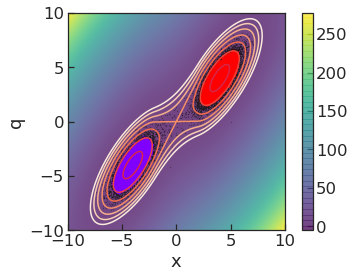

In [38]:
fig, ax = plt.subplots()#figsize=(4,4)
# histogram data
assign = hdb.labels_ >= 0
ax.scatter(data[assign,0],data[assign,1], marker='o', 
                cmap='rainbow', s=1, c=hdb.labels_[assign])
nassign = hdb.labels_ == -1
ax.scatter(data[nassign,0],data[nassign,1], marker='.', 
                cmap='rainbow', s=0.1, c='k')
lev = np.arange(-15,5,1.5)
CS = ax.contour(Xpp, Ypp, mat, levels=lev)
ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
           cmap='viridis', alpha=0.5);#RdGy
im = ax.imshow(mat, extent=[-10, 10, -10, 10], origin='lower',
           cmap='viridis', alpha=0.5);#RdGy
plt.colorbar(im)
ax.set_xlabel('x')
ax.set_ylabel('q')

If we consider clusterization good enough, proceed to lag time selection and MSM estimation

In [39]:
import pyemma.msm as msm
import pyemma.plots as mplt
lags = [1, 2, 5, 10, 20]

In [40]:
its_hdb = msm.its(hdb.labels_[assign], lags=lags, errors='bayes')

(0.1, 1000)

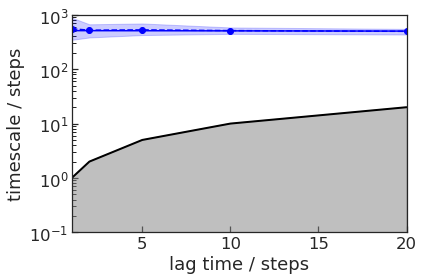

In [41]:
mplt.plot_implied_timescales(its_hdb, ylog=True)
plt.ylim(0.1,1000)

In [42]:
M_hdb = msm.estimate_markov_model(hdb.labels_[assign], 10)

In [43]:
M_hdb.timescales()

array([507.81713843])

Validate the obtained HDBSCAN MSM by carrying out the corresponding Chapman-Kolmogorov test.

In [44]:
M = msm.bayesian_markov_model(hdb.labels_[assign], 10)

In [45]:
ck = M.cktest(2)

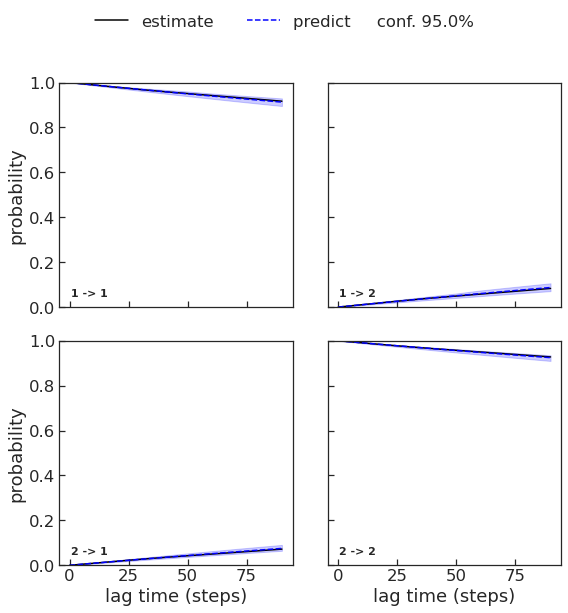

In [46]:
plt.rcParams.update({'font.size': 11})
fig, axes = mplt.plot_cktest(ck, figsize=(9, 9), padding_between=0.15, padding_top=0.13)